## Project: **Finding Lane Lines on the Road** 
***

Author : Mouad HADJI, Oct 11th, 2017

In this project, I will explain how to identify lane lines on the road. I will use primarily Python and OpenCV. The end goal will be to showcase how the code can find lane lines "live" in a video.

Several techniques are used :

- Color Selection
- Gaussian smoothing
- Canny Edge Detection
- Region of Interest Selection
- Hough Transform Line Detection
- etc.

## 1. Import Packages

We first import some useful packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import sys
import glob
%matplotlib inline

## 2. Good to know for this task

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


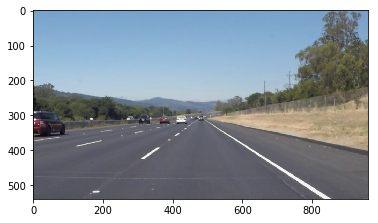

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)
# if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

### Ideas for Lane Detection Pipeline

**Some OpenCV functions that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

## 3. Helper Functions

Below are some helper functions that we will use in the code.

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold=50, high_threshold=150):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size=15):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


'''def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)'''

def draw_lines(image, lines, color=[255, 0, 0], thickness=2):

    image = np.copy(image)
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

def hough_lines(img, rho=1, theta=np.pi/180, threshold=25, min_line_len=20, max_line_gap=300):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

'''def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img'''

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## 4. Test Images

We first check the images in the test_images directory

In [4]:
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

We then load the images in a list called "test_images"

In [5]:
test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]

We define a custom function that will show a grid of images

In [7]:
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

We can see here the 8 images that we will use to test our pipeline

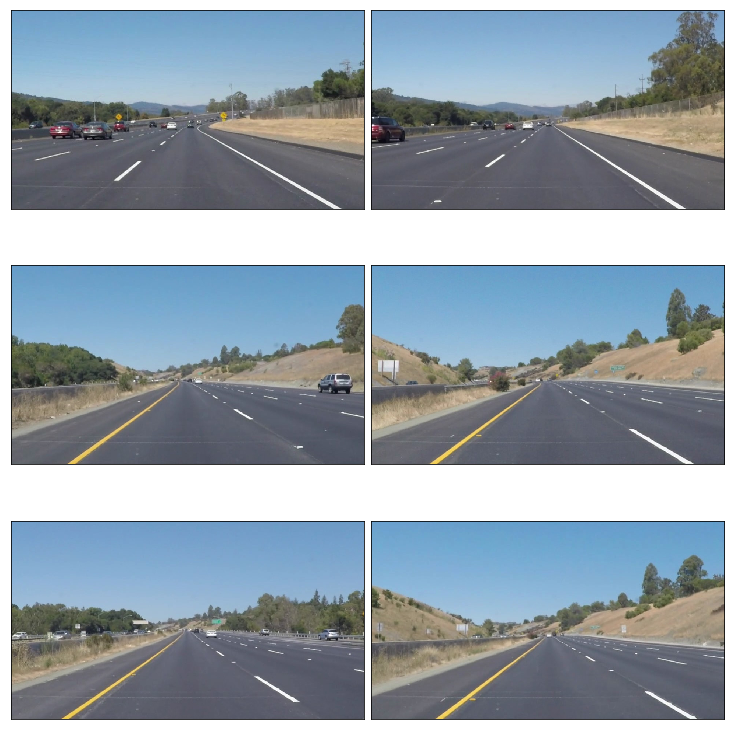

In [8]:
show_images(test_images)

## 5. Build a Lane Finding Pipeline



Goal: Build a pipeline that will draw lane lines on the test_images then save them to the test_images directory.

### 5.a. Gray scale conversion and Color conversion

#### Grayscaling

We first apply gray scaling to the images and display them. This helps reduce the number of channels to work with.

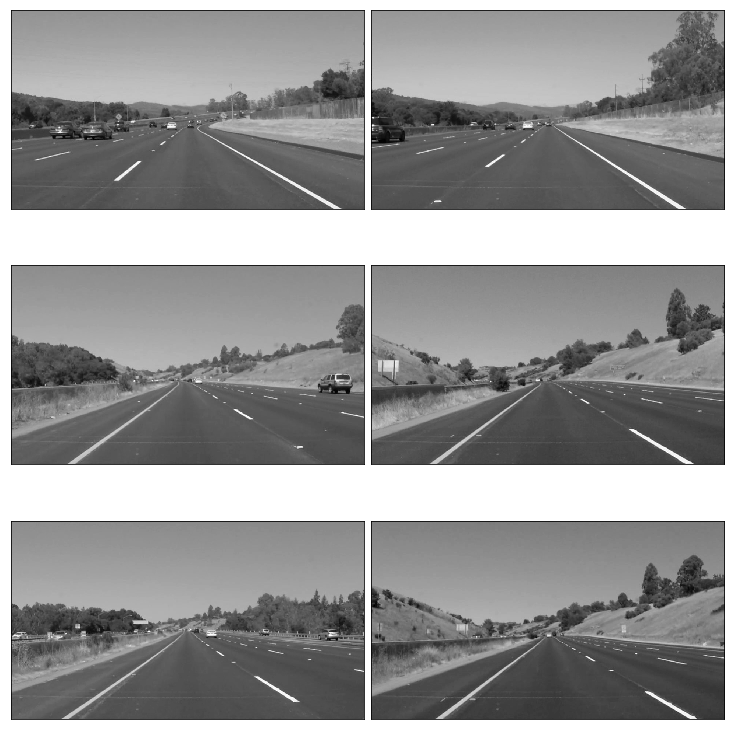

In [9]:
# grayscaling the image
gray_images = [grayscale(image) for image in test_images]

# printing out the image
show_images(gray_images, cmap='gray')

However, this is often not with more complicated images. An additionnal step we can take here is to use [HSL (Hue, Saturation, Lightness)](https://www.wikiwand.com/en/HSL_and_HSV) color selection. HSV conversion helps less, especially with white lanes.

#### HSL Color selection

For this matter, we will be using cv2.cvtColor, which can convert RGB image into different color spaces : 

In [10]:
def rgb_to_hls(image):
    hls_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    return hls_image

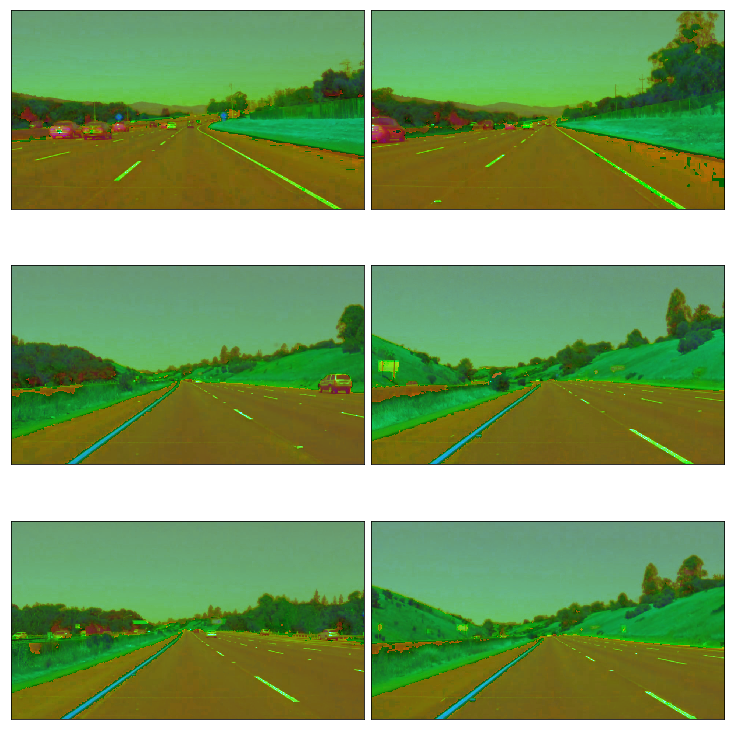

In [11]:
hls_images = [rgb_to_hls(image) for image in test_images]

show_images(hls_images)

White and yellow lanes are indeed very clear and we cannow try to extract the white and yellow lanes by selecting the particular range of each channels (Hue, Saturation and Light) that identify those colors :

In [12]:
def select_white_and_yellow(image):
    # converting to HLS
    hls_image = rgb_to_hls(image)

    # defining the bounds of each color
    lower_white = np.uint8([20,200,0])
    upper_white = np.uint8([255,255,255])
    lower_yellow = np.uint8([10,50,100])
    upper_yellow = np.uint8([100,255,255])
    
    # extracting masks
    white_mask = cv2.inRange(hls_image, lower_white, upper_white)
    yellow_mask = cv2.inRange(hls_image, lower_yellow, upper_yellow)
    
    # combining masks
    combined_mask = cv2.bitwise_or(white_mask, yellow_mask)

    return cv2.bitwise_and(image, image, mask = combined_mask)

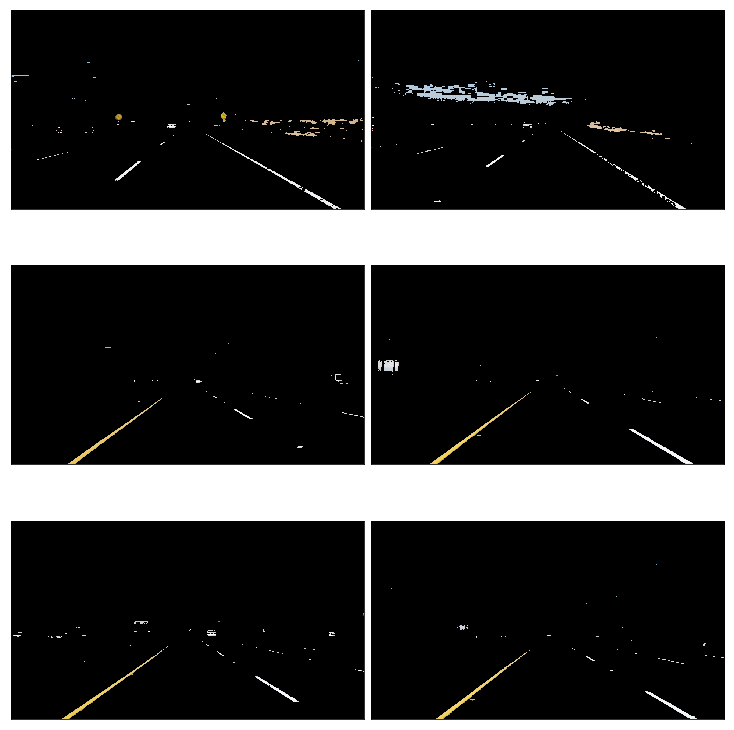

In [13]:
white_yellow_images = [select_white_and_yellow(image) for image in test_images]

show_images(white_yellow_images)

### 5.b. Gaussian smoothing

To improve the pipeline, we apply Gaussian smoothing before running Canny to suppress noise and spurious gradients

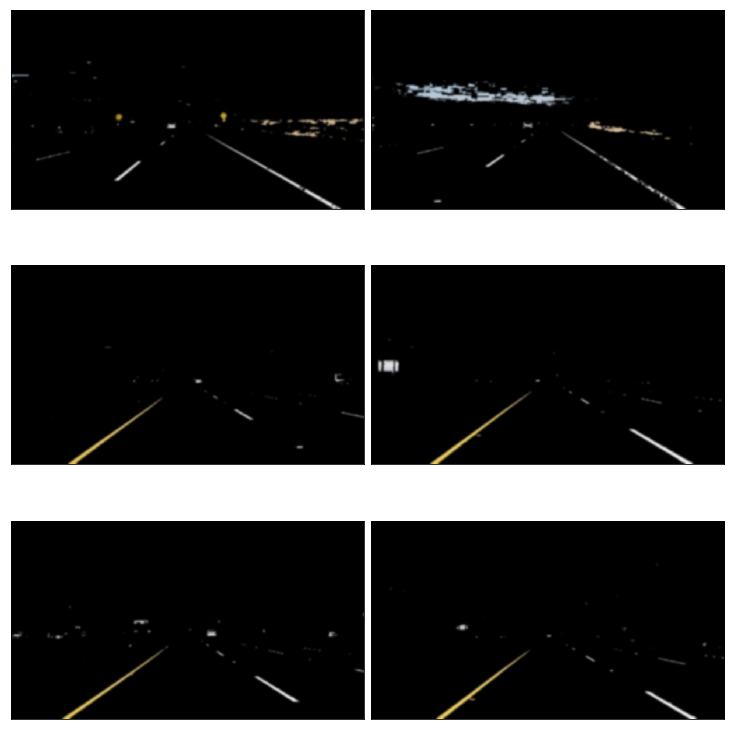

In [14]:
blur_gray_images = [gaussian_blur(white_yellow_image) for white_yellow_image in white_yellow_images]

show_images(blur_gray_images)

### 5.c. Apply Canny transform

Right after, we are applying Canny to the blurred images and our output will be a list of images called edges_images that help us detect strong edges

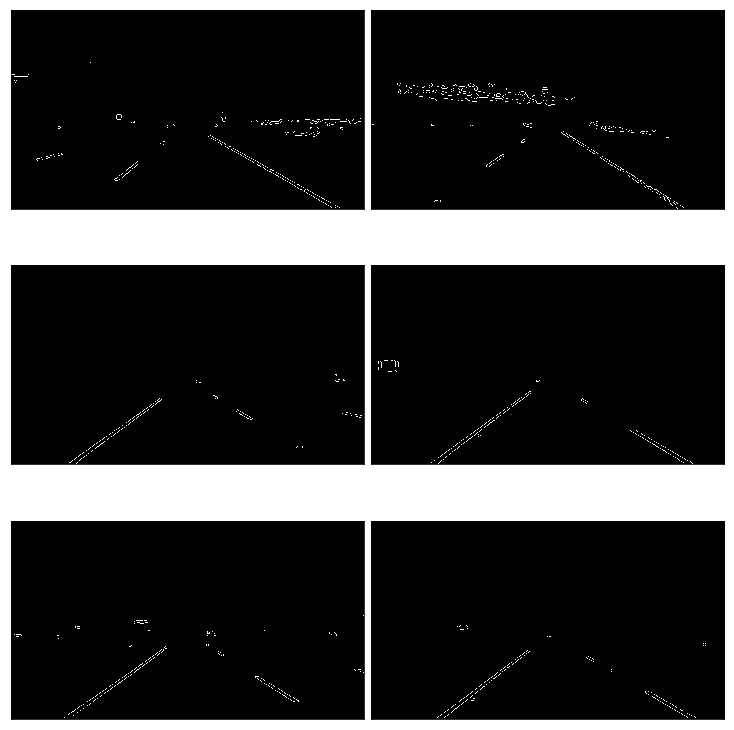

In [15]:
edges_images = [canny(blur_gray) for blur_gray in blur_gray_images]

# Display the image
show_images(edges_images, cmap='Greys_r')

### 5.d. Choosing region of interest

To focus only on the lanes, we define a polygon mask that help us filter out the elements of the images that do not help us for road lanes detection

In [16]:
imshape = test_images[0].shape
imshape

(540, 960, 3)

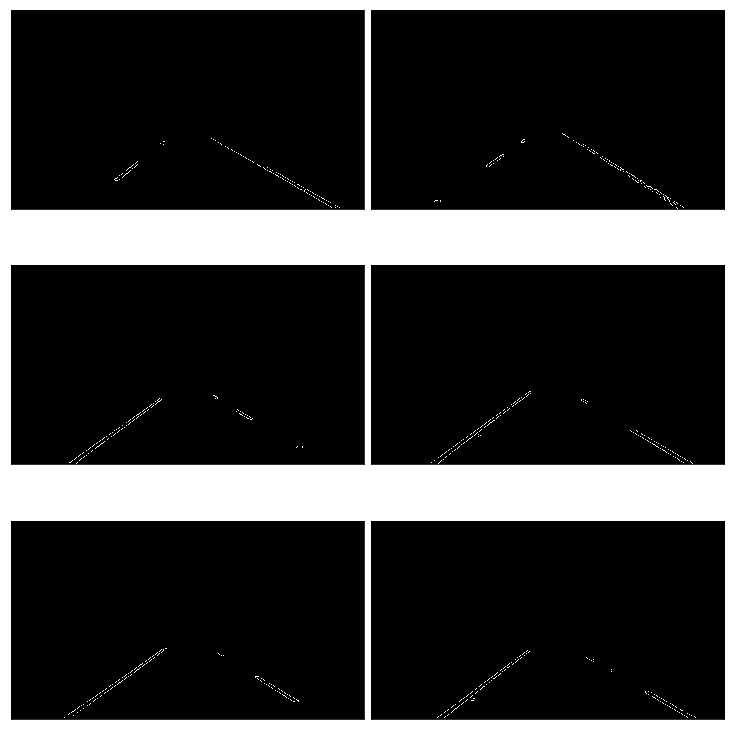

In [17]:
# We are defining a four sided polygon to mask
chosen_vertices = np.array([[
    (imshape[1]*0.05, imshape[0]),
    (imshape[1]*0.48, imshape[0]*0.6),
    (imshape[1]*0.52, imshape[0]*0.6),
    (imshape[1]*0.95, imshape[0])
]], dtype=np.int32)

masked_images = [region_of_interest(edge_image, chosen_vertices) for edge_image in edges_images]

# Display the image
show_images(masked_images, cmap='Greys_r')

### 5.e. Applying Hough transformation

We detect line segments by using the Hough transformation. As a reminder :

- rho = distance resolution in pixels of the Hough grid
- theta = angular resolution in radians of the Hough grid
- threshold = minimum number of votes (intersections in Hough grid cell)
- min_line_len = minimum number of pixels making up a line
- max_line_gap = maximum gap in pixels between connectable line segments

In [18]:
set_of_lines = [hough_lines(masked_image) for masked_image in masked_images]

In [19]:
line_img = np.zeros_like(test_images[0])

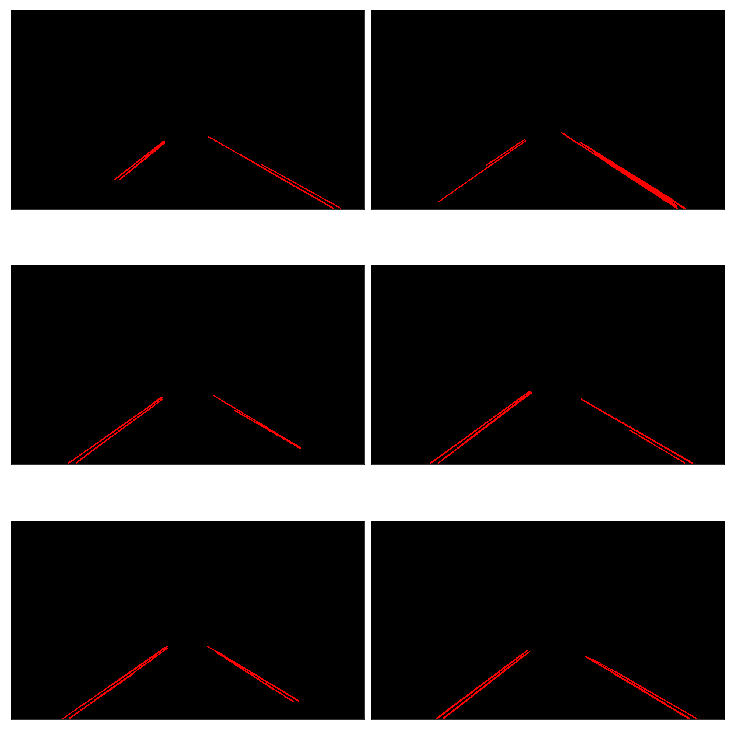

In [20]:
hough_edges_image = [draw_lines(line_img, lines) for lines in set_of_lines]

show_images(hough_edges_image)

### 5.f. Drawing lines

We eventually draw the lines on the edge image to see the results and check calibration.

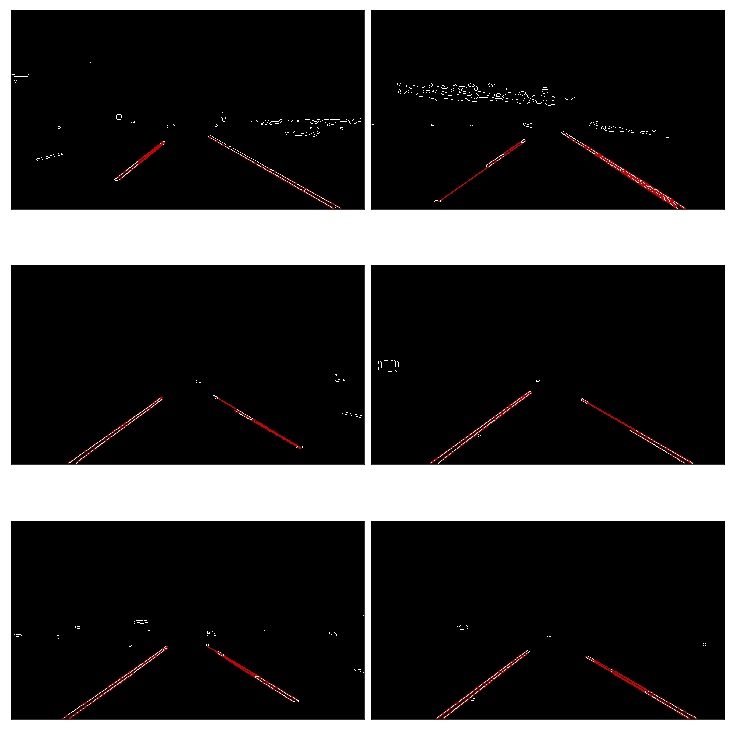

In [21]:
color_edges_images = [np.dstack((edges, edges, edges)) for edges in edges_images]
weighted_images = [weighted_img(color_edges, hough_edges) for color_edges, hough_edges in zip(color_edges_images, hough_edges_image)]

show_images(weighted_images)

### 5.g. Averaging and Extrapolating Lines

The goal of this section is to average of the detected lines into 2 very recognizable lines that represent the lane lines. For this purpose, we should come up with an averaged line for that.

Also, because some of the lane lines are only partially recognized, we will need to extrapolate the line to cover full lane line length.

In a nutshell, we need to display two lane lines: one for the left and the other for the right. The left lane should have a positive slope, and the right lane should have a negative slope. Therefore, we'll collect positive slope lines and negative slope lines separately and take averages without forgetting that the y coordinate is reversed in our pictures. Hence, Left image = negative slope and Right image = positive slope.

In [22]:
def average_lines(lines):
    left_lines    = []
    left_weights  = []
    right_lines   = []
    right_weights = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore a vertical line
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0 and length > 10:
                left_lines.append((slope, intercept))
                left_weights.append((length))
            elif slope > 0 and length > 10:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    
    left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)> 0 else None
    
    return left_lane, right_lane # (slope, intercept), (slope, intercept)

Now that we have the attributes of our lanes, there are 3 steps we need to go through in order to display the generated lines on our images :
- i. Find the end points of our lines so we can use the cv2.line function to generate a line (ii)
- ii. Generate the line points given the pixels points we calculated
- iii. Draw the lines on the images to make them clearly visible

In [23]:
image.shape

(540, 960, 3)

In [25]:
def find_end_points(image, lane):
    
    # This is used to prevent the error in the test clip #3
    if lane is None:
        return None
    
    slope, intercept = lane
    
    # retrieving the image shape
    image_shape = image
    
    y1 = image.shape[0] # bottom of the picture
    y2 = y1*0.6 # middle of the picture
    
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))

In [26]:
def generate_lane_lines(image, lines):
    
    # Step 1 : retrieving the lanes attributes we get by averaging
    left_lane, right_lane = average_lines(lines)
    
    # Step 2 : retrieving the end points
    left_points = find_end_points(image, left_lane)
    right_points = find_end_points(image, right_lane)
    
    return left_points, right_points

In [27]:
def draw_lane_lines(image, lines_points, color=[255, 0, 0], thickness=20):
    
    line_image = np.zeros_like(image)
    
    for line_points in lines_points:
        if line_points is not None:
            cv2.line(line_image, *line_points,  color, thickness)
    
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)

In [28]:
generated_lane_lines = [generate_lane_lines(image, line) for image, line in zip(test_images, set_of_lines)]
lane_images = [draw_lane_lines(image, lane_line) for image, lane_line in zip(test_images, generated_lane_lines)]

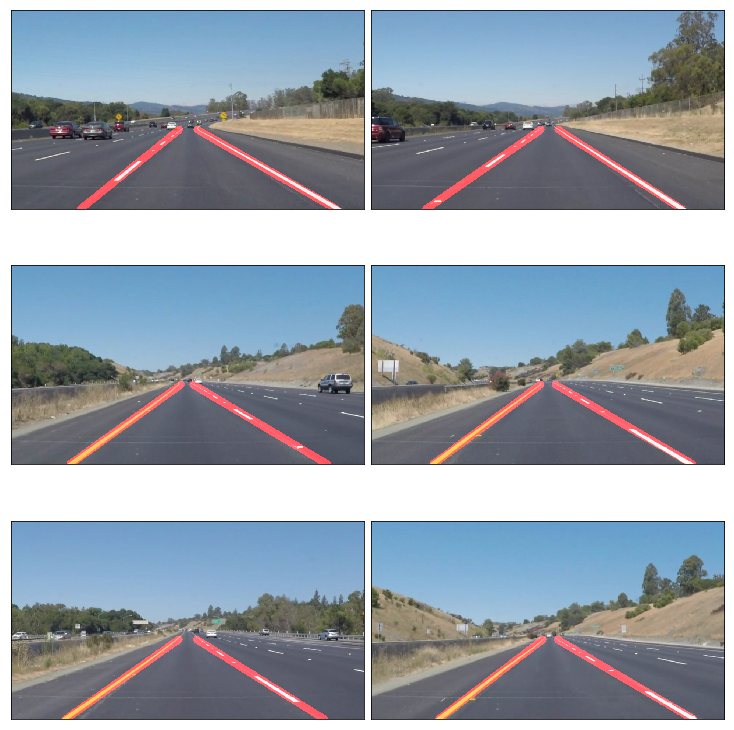

In [29]:
show_images(lane_images)

Perfect ! Let's create the pipeline now.

### 5.h. Pipelining

In [32]:
class lane_detection:
    
    def __init__(self):
        self.left_lines_historical  = []
        self.right_lines_historical = []
    
    # this has been added after noticing jitter on the videos
    def average_with_previous(self, line, lines):
        if line is not None:
            lines.append(line)
            
        if len(lines) > 0:
            line = np.mean(lines, axis=0, dtype=np.int32)
            line = tuple(map(tuple, line))
            
        return line    
        
        
    def pipeline(self, image):
        imshape = image.shape
        gray_image = grayscale(image)
        white_yellow_image = select_white_and_yellow(image)
        blur_gray = gaussian_blur(white_yellow_image)
        edge_image = canny(blur_gray)
        chosen_vertices = np.array([[(imshape[1]*0.05, imshape[0]), (imshape[1]*0.48, imshape[0]*0.6),
            (imshape[1]*0.52, imshape[0]*0.6), (imshape[1]*0.95, imshape[0])]], dtype=np.int32)
        masked_image = region_of_interest(edge_image, chosen_vertices)
        lines = hough_lines(masked_image)
        left_line, right_line = generate_lane_lines(image, lines)
        
        new_left_line  = self.average_with_previous(left_line,  self.left_lines_historical)
        new_right_line = self.average_with_previous(right_line, self.right_lines_historical)
        
        return draw_lane_lines(image, (new_left_line, new_right_line))

Let's try it on an image

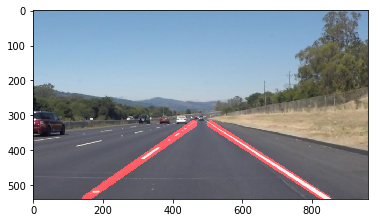

In [33]:
lane_detection = lane_detector()
output = lane_detection.pipeline(image)
plt.imshow(output)

## 6. Test on Videos

Let's take it to the next level and draw lanes over video!

We are going to test our solution on two provided videos:

- `solidWhiteRight.mp4`
- `solidYellowLeft.mp4`

In [34]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [35]:
def process_image(image):
    result = lane_detection.pipeline(image)
    return result

### 6.a First Video Clip

Let's try the one with the solid white lane on the right first ...

In [36]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:04<00:00, 53.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 6.03 s, sys: 1.13 s, total: 7.15 s
Wall time: 4.5 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### 6.b Second Video Clip

In [38]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:13<00:00, 50.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 19.6 s, sys: 3.58 s, total: 23.2 s
Wall time: 14 s


In [39]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

### 6.c Third Video Clip

In [40]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:09<00:00, 26.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 13 s, sys: 2.07 s, total: 15.1 s
Wall time: 10.3 s


In [41]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))